# Hughes model for pedestrian flow
In 1D we  can rewrite Hughes model as 
\begin{align*}
\rho_t + \nabla \cdot (\rho f(\rho) \textrm{sign} \phi_x)_x &= 0\\
\lvert \phi_x\rvert &= \frac{1}{f(\rho)}
\end{align*}
Note that the flux is discontinuous and we expect the formation of shocks at the discontinuity. 

### The 1D problem 

Let's consider the eikonal equation first
\begin{align*}
\lvert \phi'\rvert= 1 \quad \phi(0) = \phi(1) = 0
\end{align*}

* Let $\phi:[-1,1] \rightarrow \mathbb{R}$ be a classic solution. Which theorem immediately gives a contradiction  ?

Numerical methods

* Fast sweeping
* Level set formulation
* Fast marching

We use a fast sweeping method:
* H Zhao, *A fast sweeping method for eikonal equations*, Mathematics of Computation, 2005


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

In [6]:
# Initialize solver
npoints = 101 # number of gridpoints
x = np.linspace(0,1.0,npoints) # mesh
T = 1.0 # final time
nt = 1000 # number of time steps
dt = T/nt # discrete time step
dx = 1.0/npoints # interval size
lam = dt/dx
beta = 1.0 # outflow rate
rhomin = 0.5
frhomin = rhomin * (1.0-rhomin) # maximum outflux
flux = np.zeros(npoints+1)

In [3]:
def eikonal(npoints, costs):
    
    # Set the values at the boundary to zero, and inside the domain to a larger value
    phi = np.zeros(npoints)
    phi[1:-1] = 1.0
    it = 0
    dx = 1.0/npoints
    
    # Sweep from the left
    for i in np.arange(npoints-2):
        it = 1+i
        phiold = phi[it]
    
        phimin = np.minimum(phi[it-1], phi[it+1])
        phi[it] = np.minimum(phimin +  costs[it] * dx, phiold)

    # Sweep from the right
    for i in np.arange(npoints-2):
        it = 1+i
        phiold = phi[npoints-1-it]
        phimin = np.minimum(phi[npoints-1 -it+1], phi[npoints - 1- it-1])
        phi[npoints-1 -it] = np.minimum(phimin +  costs[npoints - 1 - it] * dx, phiold)

    phix = -np.gradient(phi,dx)
    return phi, phix


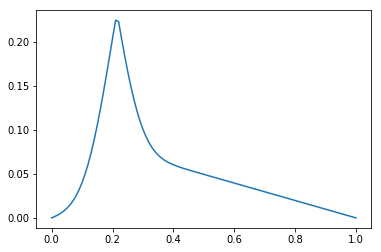

In [8]:
cost = 0.1  + 2.0 * np.exp(-(x-0.2)**2/0.01)#np.ones(npoints) #
phi,b = eikonal(npoints, cost)
plt.plot(x,phi)
plt.show()


## Nonlinear conservation laws with discontinuous flux

Such problems were analysed and solved by Towers and co-workers in a series of papers. In particular they considered a 1d problem

\begin{align*}
\partial_t u (x,t) = (k(x) f(u))_x
\end{align*}
where $k$ is stationary but can have jump discontinuities.
The developed numerical schemes have the form
\begin{align*}
u^{n+1}_j = u^n_j + \lambda (k_{j + \frac{1}{2}} h_{j + \frac{1}{2}} - k_{j - \frac{1}{2}} h_{j - \frac{1}{2}}) 
\end{align*}
where $\lambda = \frac{\Delta t}{\Delta x}$ and the arguments of the numerical flux have to be transposed if the flux changes sign (to ensure monotonicity of the scheme):
\begin{align*}
h_{j+\frac{1}{2}} &=
\begin{cases}
h(u_{j+1},u_j) \text{ if } k_{j+\frac{1}{2}} \geq 0\\
h(u_j,u_{j+1}) \text{ if } k_{j+\frac{1}{2}} < 0.
\end{cases}
\end{align*}
Different numerical fluxes were analysed - Godunov or EO flux. For further information see
* J Towers, *Convergence of a finite difference scheme for conservation laws with a discontinuous flux*, SIAM J Numer. Anal., 38(2), 2000

In [10]:
def hughes(self, rho, rhoold, npoints):
    
    # Solve eikonal equation in every time step
    [phi2,b] = eikonal(npoints,1.0/(1.0-rho))

    # Determine where the flux is positive and negative
    bmid = 0.5*(b[1:] + b[:-1])
    bplus = np.array(1.0 * (bmid >0.0))
    bmin = np.array(1.0 * (bmid <0.0))
    bcalc = np.concatenate([[0],bmid,[0]])
    
    rho1 = np.maximum(rho,rhomin)
    rho2 = np.minimum(rho,rhomin)
    
    f = rho[:] * (1.0-rho[:])
    
    # Godunov flux - calculate the solution to the corresponding Riemann problem
    nextisbigger = 1.0 * (rho[1:]>rho[:-1])
    fmin = np.minimum(f[1:],f[:-1])
    fmax = np.maximum(f[1:],f[:-1])

    flux[1:-1] = bplus[:] * (nextisbigger[:] * fmin + (1.0-nextisbigger[:]) * fmax) + (1.0-bplus[:]) * (nextisbigger[:] * fmax + (1.0-nextisbigger[:]) * fmin)
   
    rho[0] = rho[0] - lam * beta * rho[0]
    rho[1:-1] = rho[1:-1] - lam * (flux[2:-1] * bcalc[2:-1] - flux[1:-2] * bcalc[1:-2])
    rho[npoints-1] = rho[npoints-1] - lam * beta * rho[npoints-1]
    line.set_data(x,rho)
    
    rhoold[:] = rho
    line.set_data(x,rho)

# Set initial datum - solver works only for initial data smaller than 0.5 correctly, for larger values the boundary
# conditions have to be implemented correctly.

rhoinit = 0.5
rho = rhoinit * np.ones(npoints)
rhoprev = rhoinit * np.ones(npoints)
# Set figure properties for the movie
fig1, ax1 = plt.subplots(1,1)
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 0.5)

line, = ax1.plot([],[],lw=2,color="b")
anim2 = animation.FuncAnimation(fig1, hughes, fargs=(rho,rhoprev,npoints), frames=200, interval=20, blit=False)
HTML(anim2.to_html5_video())